In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/dlts-project'

/content/drive/MyDrive/dlts-project


In [ ]:
# import zipfile
# from tqdm import tqdm

# zip_path = "Data/train.zip"
# extract_path = "Data/"

# with zipfile.ZipFile(zip_path, 'r') as z:
#     for file in tqdm(z.namelist(), desc="Extracting files"):
#         z.extract(file, extract_path)

In [ ]:
# !pip install mir_eval

In [ ]:
#import sounddevice as sd
from Datasets.Audiodata import *
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import IPython
import mir_eval

In [ ]:
import warnings

# Disable all warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = Audiodataset(set='train_small')
print(len(dataset))

50


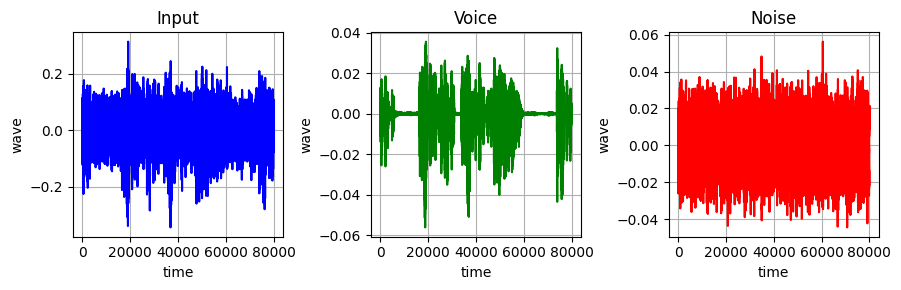

In [ ]:
dataset.take_wave()
dataset.plot(0)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:704: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]


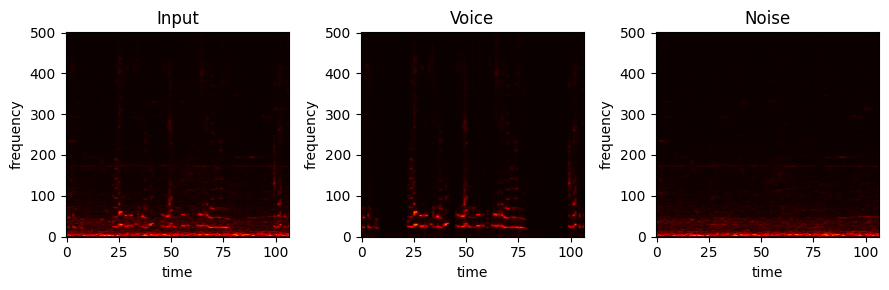

In [ ]:
dataset.take_spectrogram()
dataset.plot(0)
plt.savefig('Figs/sp.png')

In [ ]:
idx = 2
sr = 8000

test_dataset = Audiodataset('test', padding=True)
test_dataset.return_only_voice()
test_dataset.take_spectrogram()
X, VoiceSP = test_dataset[idx]

reconstruct = test_dataset.reconstruct(VoiceSP, idx, reference='voice')
print(reconstruct.shape)
IPython.display.Audio(reconstruct.squeeze().numpy(), rate=sr)

torch.Size([1, 80000])


/content/drive/MyDrive/dlts-project/Datasets/Audiodata.py:206: UserWarning: A window was not provided. A rectangular window will be applied.Please provide the same window used by stft to make the inversion lossless.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:1023.)
  return torch.istft(reconstruct, n_fft=self.__n_fft, hop_length=self.__hop_length, length=original.size(1))


In [ ]:
from Models.UNet import *

In [ ]:
model = UNet().to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size = (1,512,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 256, 64]             416
       BatchNorm2d-2          [-1, 16, 256, 64]              32
         LeakyReLU-3          [-1, 16, 256, 64]               0
       EncodeBlock-4          [-1, 16, 256, 64]               0
            Conv2d-5          [-1, 32, 128, 32]          12,832
       BatchNorm2d-6          [-1, 32, 128, 32]              64
         LeakyReLU-7          [-1, 32, 128, 32]               0
       EncodeBlock-8          [-1, 32, 128, 32]               0
            Conv2d-9           [-1, 64, 64, 16]          51,264
      BatchNorm2d-10           [-1, 64, 64, 16]             128
        LeakyReLU-11           [-1, 64, 64, 16]               0
      EncodeBlock-12           [-1, 64, 64, 16]               0
           Conv2d-13           [-1, 128, 32, 8]         204,928
      BatchNorm2d-14           [-1, 128

In [ ]:
dataset = Audiodataset('train_small', getitem='concatVN')
dataset.take_spectrogram()
dataset[0][0].shape, dataset[0][1].shape

(torch.Size([501, 107]), torch.Size([1002, 107]))

In [ ]:
voice_train_dataset = Audiodataset('train_small',padding = True,  getitem='voice')
voice_train_dataset.take_spectrogram()

voice_test_dataset = Audiodataset('test', padding = True,getitem='voice')
voice_test_dataset.take_spectrogram()

In [ ]:
voice_model, voice_losses = UNet.trainModel(voice_train_dataset, data_type='Voice', n_epochs=10, batch_size=16, learning_rate=0.0001, valid_dataset=voice_test_dataset)

[]


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

Epoch 1/10 - Train Loss: 10933.8387


Valid Loss: 4762.1278
Valid Loss: 4762.1278
SDR: -0.9460, SIR: inf, SAR: -0.9460, NSDR: -3.1820


100%|██████████| 4/4 [00:01<00:00,  3.89it/s]

Epoch 2/10 - Train Loss: 9010.9079


Valid Loss: 4743.2852


KeyboardInterrupt: 

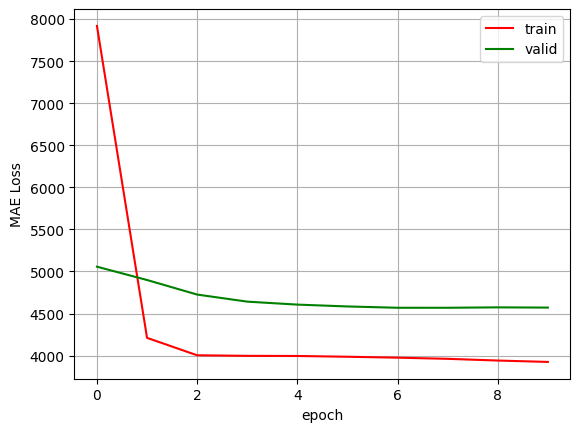

In [ ]:
voice_scores_UNet = pd.read_csv('Scores/UNet/Voice/UNetSAE.csv')
voice_train_error = voice_scores_UNet['train']
voice_valid_error = voice_scores_UNet['valid']
plt.plot(voice_train_error, color='red', label='train')
plt.plot(voice_valid_error, color='green', label='valid')
plt.grid()
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MAE Loss')
plt.savefig('Figs/VoiceUNetLoss.png')

In [ ]:
idx = 2
X, Y = voice_test_dataset[idx]
#model = UNet()
#model.load_state_dict(torch.load('Paths/WaveUNet/model_10.pth'))
output = voice_model(X.unsqueeze(0).unsqueeze(0).to(device))

(512, 128) (512, 128)


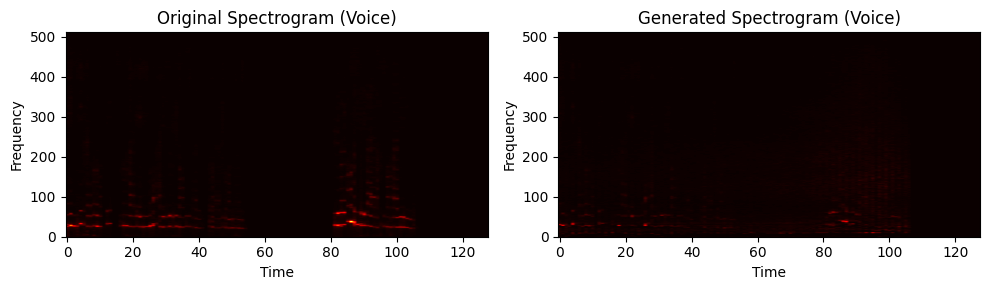

In [ ]:
Vtrue = Y.detach().cpu().numpy()  # Move to CPU before converting to NumPy
Vpred = output.squeeze().detach().cpu().numpy()  # Move to CPU before converting to NumPy
print(Vpred.shape, Vtrue.shape)
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].imshow(Vtrue, aspect='auto', origin='lower', cmap='hot')
axs[0].set_title('Original Spectrogram (Voice)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Frequency')

axs[1].imshow(Vpred, aspect='auto', origin='lower', cmap='hot')
axs[1].set_title('Generated Spectrogram (Voice)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
output.shape

torch.Size([1, 1, 512, 128])

In [ ]:
reconstructed_true = voice_test_dataset.reconstruct(Y, id0=idx, reference = 'voice')
IPython.display.Audio(reconstructed_true.detach().numpy(), rate=8000)

torch.Size([1, 80000])


In [ ]:
reconstructed_output = voice_test_dataset.reconstruct(output.cpu(), id0=idx, reference='voice')
IPython.display.Audio(reconstructed_output.detach().numpy(), rate=8000)

torch.Size([1, 80000])


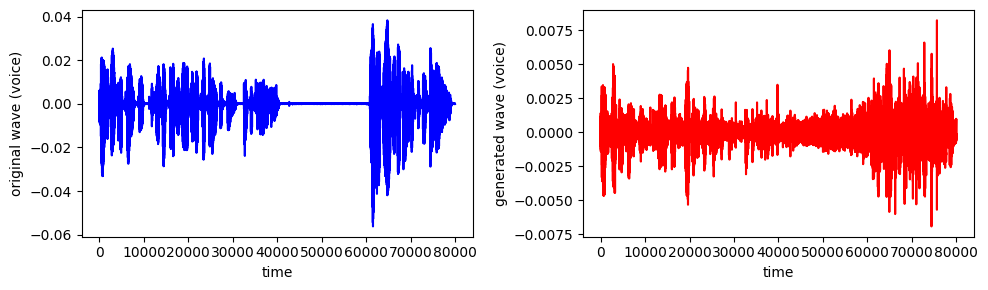

In [ ]:
S_true = reconstructed_true.squeeze().detach().numpy()
S_pred = reconstructed_output.squeeze().detach().numpy()
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(S_true, color='blue')
axs[0].set_xlabel('time')
axs[0].set_ylabel('original wave (voice)')

axs[1].plot(S_pred, color='red')
axs[1].set_xlabel('time')
axs[1].set_ylabel('generated wave (voice)')

plt.tight_layout()

In [ ]:
# noise_train_dataset = Audiodataset('train_small',padding = True, getitem='noise')
# noise_train_dataset.take_spectrogram()

# noise_test_dataset = Audiodataset('test',padding = True, getitem='noise')
# noise_test_dataset.take_spectrogram()

In [ ]:
# noise_scores_WaveUNet = pd.read_csv('Scores/UNet/Noise/UNetSAE.csv')
# noise_train_error = noise_scores_WaveUNet['train']
# noise_valid_error = noise_scores_WaveUNet['valid']
# plt.plot(noise_train_error, color='red', label='train')
# plt.plot(noise_valid_error, color='green', label='valid')
# plt.grid()
# plt.legend()
# plt.xlabel('epoch')
# plt.ylabel('MAE Loss')
# plt.savefig('Figs/NoiseUNetLoss.png')